In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from imutils import contours
import shutil


%matplotlib inline

In [2]:
def calcCoordinates(line):
    rho,theta = line.reshape(-1)
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 100000*(-b))
    y1 = int(y0 + 100000*(a))
    x2 = int(x0 - 100000*(-b))
    y2 = int(y0 - 100000*(a))
    
    return x1, y1, x2, y2

def calcTangent(x1, y1, x2, y2):
    if (y2 - y1) != 0:
        return abs((x2-x1) / (y2 - y1))
    else:
        return 1000

def getLines(image, filter = True):
    
    '''
    The method finds each sudoku cell with Lines
    '''
    
    # apply some preprocessing before applying Hough transform
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,90,150,apertureSize = 3)
    kernel = np.ones((3, 3),np.uint8)
    edges = cv2.dilate(edges,kernel,iterations = 1)
    kernel = np.ones((5, 5),np.uint8)
    edges = cv2.erode(edges,kernel,iterations = 1)



    # find lines on the preprocessed image u|sing Hough Transform
    lines = cv2.HoughLines(edges,1,np.pi/180,400)

    
    if not lines.any():
        print('No lines were found')
        exit()

    # calculate how many horizontal lines were found
    tot = 0
    for line in lines:
        x1, y1, x2, y2 = calcCoordinates(line)
        
        tan = calcTangent(x1, y1, x2, y2)
        if tan > 1000:
            tot += 1
      
    boundaryLines = np.asarray([[0, 0], [1, 1.5707964e+00], [image.shape[1], 0], [image.shape[0], 1.5707964e+00]]).reshape(-1, 1, 2)
    lines = list(np.concatenate([np.asarray(lines), boundaryLines], axis = 0))
    # remove redundant lines which do not  fit into the crossword pattern
    if filter:
        rho_threshold = image.shape[0] / (tot + 1)
        theta_threshold = 0.01

        # how many lines are similar to a given one
        similar_lines = {i : [] for i in range(len(lines))}
        for i in range(len(lines)):
            for j in range(len(lines)):
                if i == j:
                    continue

                rho_i,theta_i = lines[i][0]
                rho_j,theta_j = lines[j][0]
                if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                    similar_lines[i].append(j)

        # ordering the INDECES of the lines by how many are similar to them
        indices = [i for i in range(len(lines))]
        indices.sort(key=lambda x : len(similar_lines[x]))

        # line flags is the base for the filtering
        line_flags = len(lines)*[True]
        for i in range(len(lines) - 1):
            if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
                continue

            for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
                if not line_flags[indices[j]]: # and only if we have not disregarded them already
                    continue

                rho_i,theta_i = lines[indices[i]][0]
                rho_j,theta_j = lines[indices[j]][0]
                if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                    line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

    print('number of Hough lines:', len(lines))

    filtered_lines = []

    if filter:
        for i in range(len(lines)): # filtering
            if line_flags[i]:
                filtered_lines.append(lines[i])

        print('Number of filtered lines:', len(filtered_lines))
    else:
        filtered_lines = lines
        

    # draw the lines on the image and mask and save them
    mask = np.zeros_like(img)
    final_lines = []
    for line in filtered_lines:
        x1, y1, x2, y2 = calcCoordinates(line)
        tan = calcTangent(x1, y1, x2, y2)
        if tan > 1000 or tan == 0:
            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
            cv2.line(mask,(x1,y1),(x2,y2),(0,0,255),2)
            final_lines.append(line)


    cv2.imwrite('hough.jpg',img)
    cv2.imwrite('mask.jpg',mask)
    
    return final_lines, (img, mask)

In [3]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    x11, y11, x21, y21 = calcCoordinates(line1)
                    x12, y12, x22, y22 = calcCoordinates(line2)
                    
                    tan1 = calcTangent(x11, y11, x21, y21)
                    tan2 = calcTangent(x12, y12, x22, y22)
                    
                        
                    if abs(tan1 - tan2) > 0.5:
                        intersections.append(intersection(line1, line2)) 

    return intersections

In [4]:
import pandas as pd
def correctLines(lines):
    '''
    Adds some lines in case missing from standard methods
    '''
    
    lineDists = pd.DataFrame(np.asarray(lines).reshape(-1, 2))
    lineDists.iloc[:, 1] = (lineDists.iloc[:, 1] > 0).apply(int)
    lineDists = lineDists.sort_values(by = [1, 0])
    lineDists.columns = ['rho', 'theta']
    lineDists['rho'] = lineDists['rho'].apply(int)
    newLines = []
    for value in lineDists['theta'].unique():
        curDists = lineDists[lineDists['theta'] == value]
        curDists['delta'] = curDists['rho'] - curDists['rho'].shift(1).fillna(0)

        med = np.median(curDists['delta'].values)
        for index, dist in enumerate(curDists['delta'].values):
            if dist > 1.5 * med:
                newLines.append(np.array([(curDists.iloc[index-1, 0] + curDists.iloc[index, 0]) // 2, value]).reshape(1, 2))
    return lines + newLines
    

In [5]:
os.listdir('data/')

['fa2_1_no_text.png', 'l1.png', 'p1_1.png', 'test', 'train']

In [6]:
os.listdir('data/test/')

['fa1_1_no_text.png', 'p2_1.png', 'p3_1.png', 'S1.png']

In [7]:
path = 'data/test/' + os.listdir('data/test')[2]
print(path)
img = cv2.imread(path)

# find crossword lines
lines, (image, mask) = getLines(img, filter = True)

# corrects some missing lines
lines = correctLines(lines)

# find line intersection points
intersections = segmented_intersections(lines)

data/test/p3_1.png
number of Hough lines: 36
Number of filtered lines: 33


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


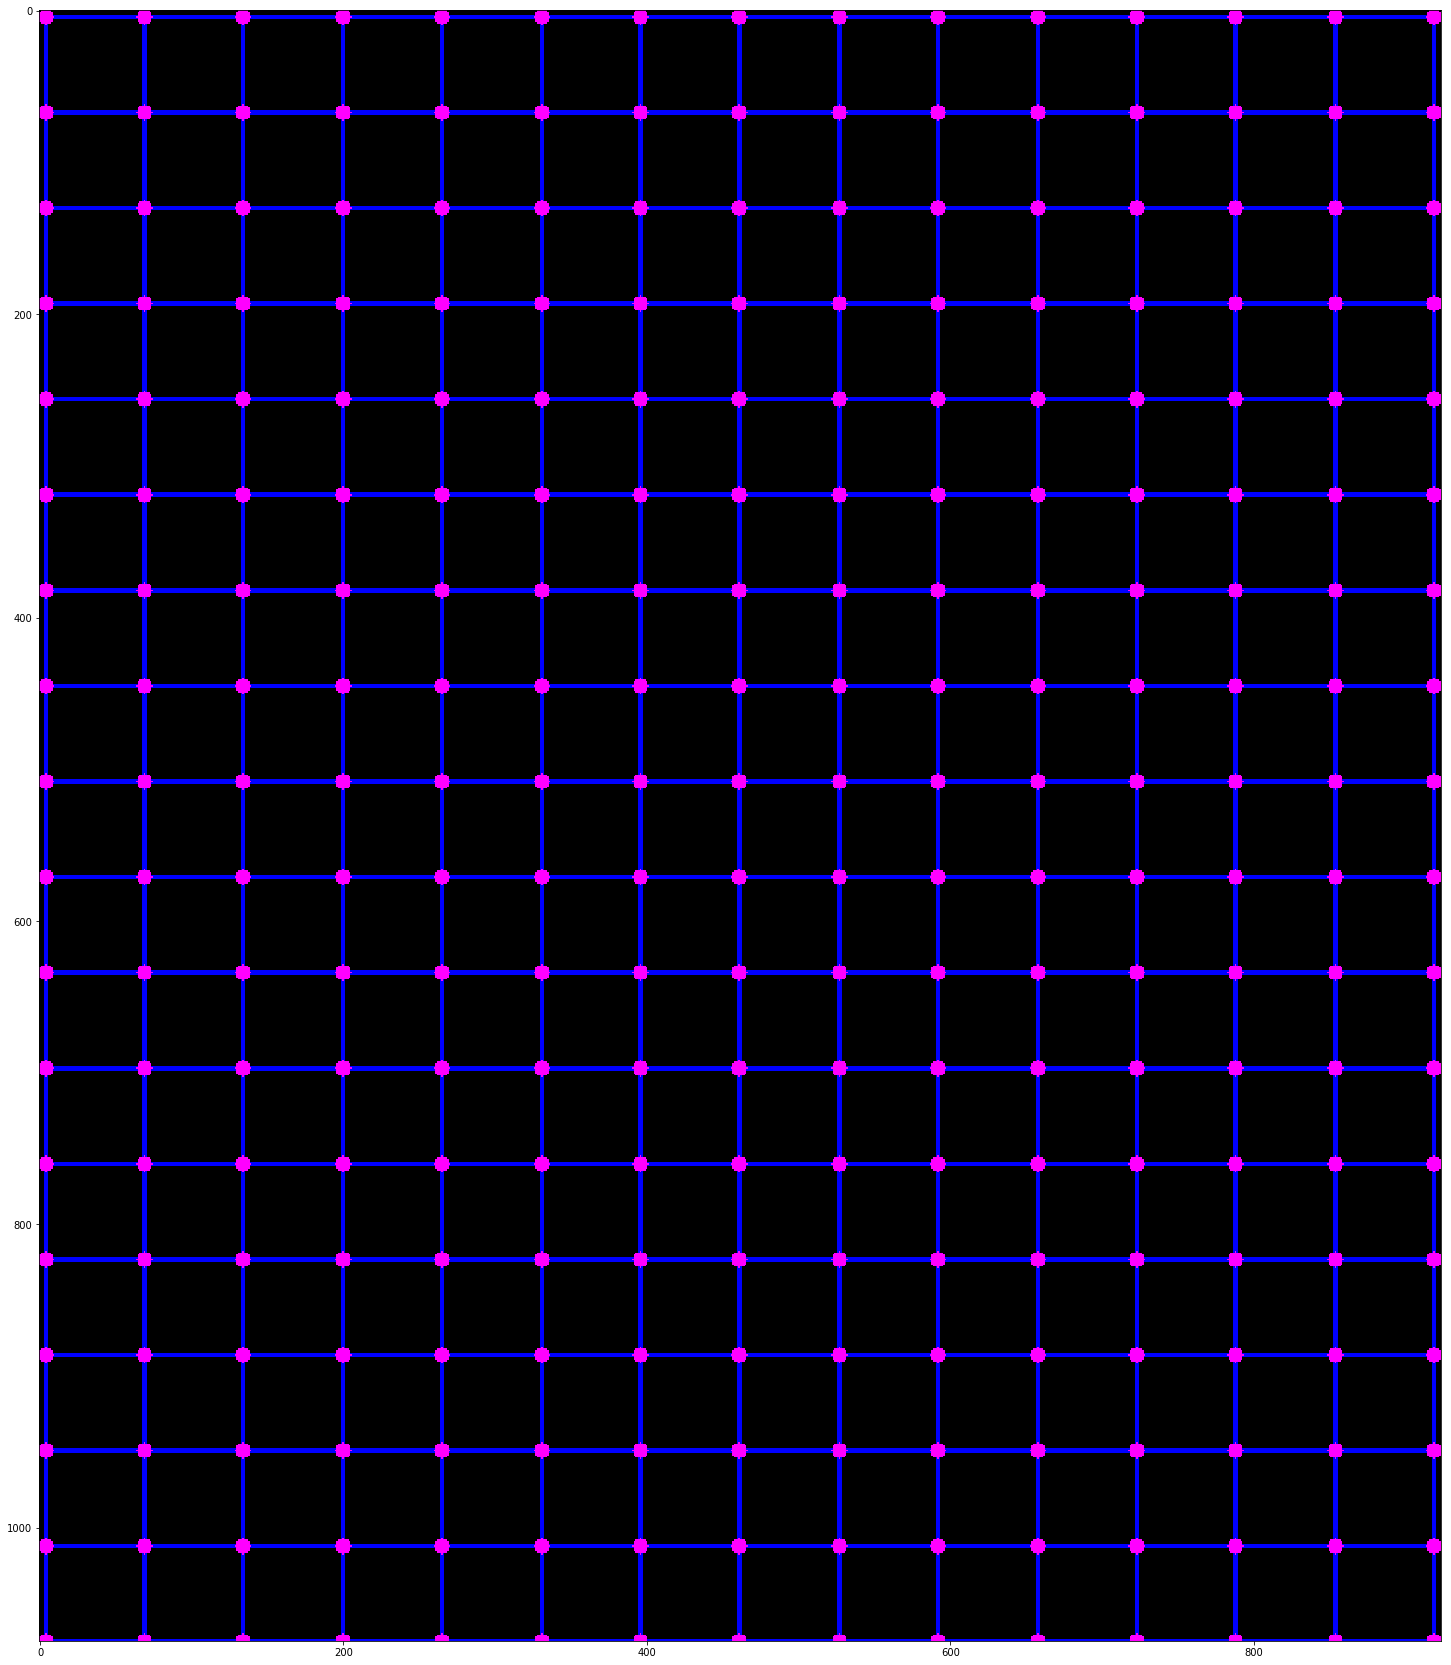

In [8]:
pointMask = mask.copy()
for point in np.asarray(intersections):
    x, y = point.reshape(-1,)
    pointMask = cv2.circle(pointMask, (x,y), 5, (255, 0, 255), -1, )
plt.figure(figsize = (30, 30))
plt.imshow(pointMask)

In [9]:
# cut each cell separately and place it into the tmp folder
path = 'tmp/'

shutil.rmtree(path, ignore_errors = True)

try:
    os.mkdir(path)
except:
    pass

xs = sorted(np.unique(np.asarray(intersections)[:, 0, 0]))
ys = sorted(np.unique(np.asarray(intersections)[:, 0, 1]))
for i, x in enumerate(xs[:-1]):
    for j, y in enumerate(ys[:-1]):
        cropImage = image[y:ys[j+1], x:xs[i+1]]
        cv2.imwrite(path + f'{j}_{i}.png', cropImage)

In [28]:
# prepare the folder structure for the training data
clearFolders = False

if clearFolders:
    shutil.rmtree('training_data/', ignore_errors = True)
try:
    os.mkdir('training_data/')
    os.mkdir('training_data/right/')
    os.mkdir('training_data/down/')
    os.mkdir('training_data/both/')
    os.mkdir('training_data/inverse_arrow/')
    os.mkdir('training_data/double_text/')
    os.mkdir('training_data/single_text/')
    os.mkdir('training_data/other/')
except:
    print('Structure already created!')

Structure already created!
